<a href="https://colab.research.google.com/github/Mhammad-riyaz/Wavenet/blob/main/Wavent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
words = open("names.txt").read().splitlines()
print(words[:8])
block_size = 3
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['<S>'] = 0
stoi['<E>'] = 27
itos = {i:s for s,i in stoi.items()}
print(itos)
vocab_size = len(itos)
print(vocab_size)

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '<S>', 27: '<E>'}
28


In [ ]:
 # build the dataset
def build_dataset(words):
  X,Y = [],[]
  for w in words:
    # print(w)
    context = [0] * block_size
    for ch in list(w)+['<E>']:
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '--->',itos[ix])
      context = context[1:] + [ix]
      # print(context)
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape,Y.shape)
  return X,Y

import random
random.shuffle(words)
random.seed(42)
n1 = int(0.8 * len(words))  # 80% of the words
n2 = int(0.9 * len(words))  # 90% of the words

Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])

torch.Size([182381, 3]) torch.Size([182381])
torch.Size([22866, 3]) torch.Size([22866])
torch.Size([22899, 3]) torch.Size([22899])


In [ ]:

class Linear:

  def __init__ (self,fan_in,fan_out,bias=True):
    self.weight = torch.randn((fan_in,fan_out)) / fan_in**0.5 # fixing the staturated tanh with the first method (Kaiming He)
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self,x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out+=self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

  def __init__(self, dim,eps=1e-5,momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters trained with backprop
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with running momentum update)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__ (self,x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2 :
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else :
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x-xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma,self.beta]

class Tanh:
  def __call__ (self,x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []


In [ ]:
# Important Note :
# We are not using biased method for calculating the variance, so while sampling we get inf as the probability because the n becomes
# one as the input in the sample will be one and we will be basically dividing with 0, so we should make sure that before sampling
# we have to make the training false to stop the variance calculation.

In [ ]:
torch.manual_seed(42) # global seed for reproducibility

In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

C = torch.randn((vocab_size,n_embd))

layers = [
    Linear(n_embd*block_size,n_hidden,bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,vocab_size),
]

with torch.no_grad():
  # changing this to gamma because it the one that interact with the ouput
  layers[-1].weight *= 0.1


parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) #  total number of parameters
for p in parameters:
  p.requires_grad = True


12308


In [ ]:
# same optimization as last time

max_steps = 200_000
batch_size = 32
lossi= []
ud = []

for i in range(max_steps):

  # mini-batch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]
  x = emb.view(emb.shape[0],-1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x,Yb) # loss function


  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i%10000 == 0:
    print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
  lossi.append(loss.log10().item())


  # if i > 1000:
  #   break

      0/ 200000:3.3404
  10000/ 200000:2.3626
  20000/ 200000:2.3568
  30000/ 200000:2.4513
  40000/ 200000:2.3445
  50000/ 200000:2.0348
  60000/ 200000:1.7929
  70000/ 200000:2.2090
  80000/ 200000:2.2117
  90000/ 200000:2.1802
 100000/ 200000:2.3821
 110000/ 200000:1.8679
 120000/ 200000:2.2391
 130000/ 200000:2.2611
 140000/ 200000:2.0463
 150000/ 200000:1.8650
 160000/ 200000:2.0164
 170000/ 200000:2.1613
 180000/ 200000:2.0466
 190000/ 200000:1.8239


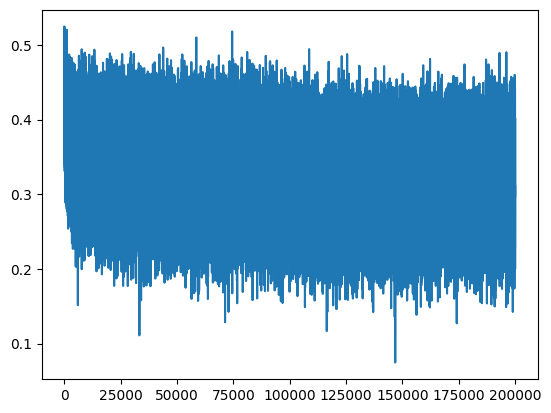

In [ ]:
plt.plot(lossi)

In [ ]:
# The loss plot looks crazy because the 32 batch size is very small, we can get sometimes lucky/unlucky because of the examples in the
# batch so it creates a thick plot.

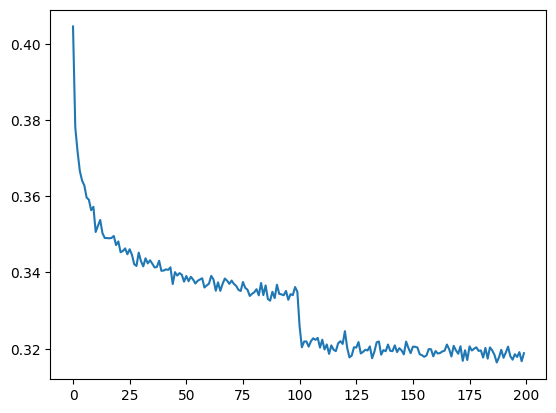

In [ ]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [ ]:
# the plot looks descent, basically we took the mean of a 1000 columns in 200 rows to get a good summary.

In [ ]:
# put layers into eval mode (needed for batchnorm espcially)
for layer in layers:
  layer.training = False

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking which makes things efficient
def split_loss(split):
  x,y = {
      'train' : (Xtr,Ytr),
      'dev' : (Xdev,Ydev),
      'test' : (Xte,Yte)
  }[split]

  emb = C[x]
  x = emb.view(emb.shape[0],-1)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x,y)
  print(split, loss.item())

split_loss("train")
split_loss("dev")

train 2.0643677711486816
dev 2.1154749393463135


In [ ]:
# sampling from the model
for i in range(20):

  context = [0] * block_size
  out = []
  while True :
    emb = C[torch.tensor([context])]
    x = emb.view(emb.shape[0],-1)
    for layer in layers:
      x = layer(x)
    logits = x
    probs = F.softmax(logits,dim=1)
    ix = torch.multinomial(probs,num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 27:
      break;
  print(''.join(itos[i] for i in out ))

aphlorah<E>
jaolkerikye<E>
eda<E>
bene<E>
izridd<E>
kolde<E>
kord<E>
axyia<E>
emikorianokhi<E>
jose<E>
trackentrej<E>
gen<E>
neva<E>
ormyn<E>
mery<E>
zarienne<E>
kailah<E>
jamarius<E>
jakynd<E>
jeilohni<E>


In [ ]:
# the results are name like but not quite good

In [ ]:
# If we look at our forward pass the we are kind of abstracted the usage of layers  we are just looping over all the layer but
# exactly not all the layers, we are using the C matrix outside and alos the view operation too, so we can add this to our classes.

In [ ]:

class Linear:

  def __init__ (self,fan_in,fan_out,bias=True):
    self.weight = torch.randn((fan_in,fan_out)) / fan_in**0.5 # fixing the staturated tanh with the first method (Kaiming He)
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self,x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out+=self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# --------------------------------------------------------------------------------------------------------------

class BatchNorm1d:

  def __init__(self, dim,eps=1e-5,momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters trained with backprop
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with running momentum update)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__ (self,x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2 :
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else :
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x-xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma,self.beta]

# --------------------------------------------------------------------------------------------------------------

class Tanh:
  def __call__ (self,x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# --------------------------------------------------------------------------------------------------------------

class Embedding: # The C matrix

  def __init__(self,num_embeddings,embedding_dim):
    self.weight = torch.randn((num_embeddings,embedding_dim))

  def __call__(self,IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]


# --------------------------------------------------------------------------------------------------------------

class Flatten: # The view operation for concatenation

  def __call__(self,x):
    self.out = x.view(x.shape[0],-1)
    return self.out

  def parameters(self):
    return []

#----------------------------------------------------------------------------------------------------------------

class Sequential: # we are looping over the layers ourself and this can be abstracted to the pytorch concept of Containers.

  def __init__(self,layers):
    self.layers = layers

  def __call__(self,x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

C = torch.randn((vocab_size,n_embd))
model = Sequential([
    Embedding(vocab_size,n_embd),
    Flatten(),
    Linear(n_embd*block_size,n_hidden,bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,vocab_size),
])

with torch.no_grad():
  # changing this to gamma because it the one that interact with the ouput
  model.layers[-1].weight *= 0.1


parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) #  total number of parameters
for p in parameters:
  p.requires_grad = True


12308


In [ ]:
# same optimization as last time

max_steps = 200_000
batch_size = 32
lossi= []
ud = []

for i in range(max_steps):

  # mini-batch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits,Yb) # loss function

  # backward pass

  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i%10000 == 0:
    print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
  lossi.append(loss.log10().item())


  # if i > 1000:
  #   break

      0/ 200000:3.3463
  10000/ 200000:2.1938
  20000/ 200000:2.2574
  30000/ 200000:1.9274
  40000/ 200000:2.3040
  50000/ 200000:2.5025
  60000/ 200000:2.3613
  70000/ 200000:1.6697
  80000/ 200000:2.3833
  90000/ 200000:2.3159
 100000/ 200000:2.1375
 110000/ 200000:2.3140
 120000/ 200000:1.9929
 130000/ 200000:2.0824
 140000/ 200000:1.8452
 150000/ 200000:2.1601
 160000/ 200000:2.2649
 170000/ 200000:2.1863
 180000/ 200000:2.2165
 190000/ 200000:2.1557


In [ ]:
@torch.no_grad() # this decorator disables gradient tracking which makes things efficient
def split_loss(split):
  x,y = {
      'train' : (Xtr,Ytr),
      'dev' : (Xdev,Ydev),
      'test' : (Xte,Yte)
  }[split]

  logits = model(x)
  loss = F.cross_entropy(logits,y)
  print(split, loss.item())

split_loss("train")
split_loss("dev")

train 2.065495014190674
dev 2.112807512283325


In [ ]:
# put layers into eval mode (needed for batchnorm espcially)
for layer in model.layers:
  layer.training = False

In [ ]:
# sampling from the model
for i in range(20):

  context = [0] * block_size
  out = []
  while True :
    x = torch.tensor([context])
    logits = model(x)
    probs = F.softmax(logits,dim=1)
    ix = torch.multinomial(probs,num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 27:
      break;
  print(''.join(itos[i] for i in out ))

hayse<E>
malizabisom<E>
simmarro<E>
anheire<E>
sika<E>
shika<E>
emmehdemanex<E>
kai<E>
aimmaley<E>
weer<E>
joury<E>
dion<E>
dhacien<E>
jamely<E>
breonoelabaylah<E>
keslaiha<E>
branyia<E>
shisabi<E>
lilania<E>
asan<E>


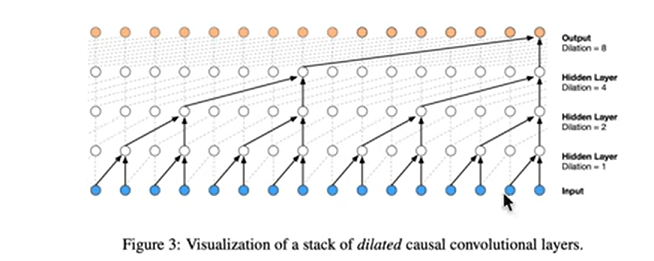

In [ ]:
# So far so good, but there is a problem here we are taking the input and squashing the inputs to the single layer (hidden layer),
# instead we squash them slowly in a hierarchial manner, we fuse the information from previous context slowly.
# At each level we fust two consecutive elements (two characters, two bigrams ,two 4-grams etc).

In [ ]:
block_size = 8 # changing the block size to 8
 # build the dataset
def build_dataset(words):
  X,Y = [],[]
  for w in words:
    # print(w)
    context = [0] * block_size
    for ch in list(w)+['<E>']:
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '--->',itos[ix])
      context = context[1:] + [ix]
      # print(context)
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape,Y.shape)
  return X,Y

import random
random.shuffle(words)
random.seed(42)
n1 = int(0.8 * len(words))  # 80% of the words
n2 = int(0.9 * len(words))  # 90% of the words

Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])

torch.Size([182460, 8]) torch.Size([182460])
torch.Size([22889, 8]) torch.Size([22889])
torch.Size([22797, 8]) torch.Size([22797])


In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

C = torch.randn((vocab_size,n_embd))
model = Sequential([
    Embedding(vocab_size,n_embd),
    Flatten(),
    Linear(n_embd*block_size,n_hidden,bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,vocab_size),
])

with torch.no_grad():
  # changing this to gamma because it the one that interact with the ouput
  model.layers[-1].weight *= 0.1


parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) #  total number of parameters
for p in parameters:
  p.requires_grad = True


22308


In [ ]:
# same optimization as last time

max_steps = 200_000
batch_size = 32
lossi= []
ud = []

for i in range(max_steps):

  # mini-batch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits,Yb) # loss function

  # backward pass

  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i%10000 == 0:
    print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
  lossi.append(loss.log10().item())


  # if i > 1000:
    # break

      0/ 200000:3.3415
  10000/ 200000:2.3518
  20000/ 200000:2.4108
  30000/ 200000:1.8957
  40000/ 200000:2.0352
  50000/ 200000:2.3472
  60000/ 200000:2.1280
  70000/ 200000:1.5774
  80000/ 200000:1.9621
  90000/ 200000:2.1527
 100000/ 200000:1.8436
 110000/ 200000:1.8508
 120000/ 200000:1.9573
 130000/ 200000:1.9818
 140000/ 200000:2.1476
 150000/ 200000:2.4634
 160000/ 200000:1.7249
 170000/ 200000:1.6652
 180000/ 200000:1.7657
 190000/ 200000:1.6188


In [ ]:
split_loss("train")
split_loss("dev")

train 1.9224162101745605
dev 2.0210511684417725


# Performance Insights

for context length 3 : we got **train-error : 2.06** and **dev-error : 2.11**

for context length 8 : we got **train-error : 1.92** and **dev-error : 2.04**

So we got some descent improvement just by increasing the context size.

In [ ]:
# lets take an example and inspect what happens in the forward pass

In [ ]:
ix = torch.randint(0,Xtr.shape[0],(4,)) # lets inspect a batch of 4 examples

Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0, 13,  1, 18],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  1,  1,  4,  9, 19]])

In [ ]:
model.layers[0].out.shape # output of our first layer, Embedding layer

torch.Size([4, 8, 10])

In [ ]:
model.layers[1].out.shape # output of Flatten layer

torch.Size([4, 80])

In [ ]:
model.layers[2].out.shape # output of Linear layer

torch.Size([4, 200])

In [ ]:
# one thing to note here is in the linear layer basically we are doing this :
(torch.randn((4,80)) @ torch.randn((80,200)) + torch.randn(200)).shape
# the matrix multiplication in pytorch is quite powerful that the first matrix can be of any dimension, it will work, for example :
(torch.randn((4,5,10,80)) @ torch.randn((80,200)) + torch.randn(200)).shape
# the matrix multiplication works only on the last dimension of the first matrix
# we can use this concept as it is convinient for us right now for the wavenet implementation

torch.Size([4, 5, 10, 200])

In [ ]:
# we have 8 characters as input: 1,2,3,4,5,6,7,8
# we don't want to matrix multiply the 80 (from above example), instead we want to group these like (1,2) (3,4) (5,6) (7,8) with
# the consecutive elements and all these four groups should be processed in parallel like batch dimension.
# so we should process them 4 groups of each example and at the same time for all the 4 (batch size) example in parallel.
# so instead of (torch.randn((4,80)) @ torch.randn((80,200)) + torch.randn(200)) feeding all in we need to only feed that two bigrams
(torch.randn((4,4,20)) @ torch.randn((20,200)) + torch.randn(200)).shape
# 1st four is the batch size with examples,
# 2nd four is the 4 groups of the bigram and
# the 3rd 20 is each bigrams (2 chars) 10 dim embedding

# so we need to change the Flatten layer to output accordingly and also the linear layer to expect the input size correctly

e = torch.randn((4,8,10))
# x = int(e.shape[1]/2)             #       -------------> one way
# print(e.view(e.shape[0],x,-1).shape)

# list(range(10))[::2] # by this we can only get even places
# list(range(10))[1::2] # by this we can only get odd places ----------------> another way
# torch.cat([e[:,::2,:], e[:, 1::2,:]],dim=2).shape

e.view((4,-1,20)).shape # -----> best way 😎


torch.Size([4, 4, 20])

In [ ]:

class Linear:

  def __init__ (self,fan_in,fan_out,bias=True):
    self.weight = torch.randn((fan_in,fan_out)) / fan_in**0.5 # fixing the staturated tanh with the first method (Kaiming He)
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self,x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out+=self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# --------------------------------------------------------------------------------------------------------------

class BatchNorm1d:

  def __init__(self, dim,eps=1e-5,momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters trained with backprop
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with running momentum update)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__ (self,x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2 : # if it's a 2 dim tensor
        dim = 0
      elif x.ndim == 3: # if it's a 3 dim tensor
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else :
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x-xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma,self.beta]

# --------------------------------------------------------------------------------------------------------------

class Tanh:
  def __call__ (self,x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# --------------------------------------------------------------------------------------------------------------

class Embedding: # The C matrix

  def __init__(self,num_embeddings,embedding_dim):
    self.weight = torch.randn((num_embeddings,embedding_dim))

  def __call__(self,IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]


# --------------------------------------------------------------------------------------------------------------

class FlattenConsecutive: # The view operation for concatenation

  def __init__(self,n):
    self.n = n

  def __call__(self,x):
    B, T, C = x.shape
    x = x.view(B,T//self.n,C*self.n)
    if x.shape[1] == 1: # dim handling
      x = x.squeeze(1) #  after this we will get B X C*n matrix
    self.out = x
    return self.out

  def parameters(self):
    return []

#----------------------------------------------------------------------------------------------------------------

class Sequential: # we are looping over the layers ourself and this can be abstracted to the pytorch concept of Containers.

  def __init__(self,layers):
    self.layers = layers

  def __call__(self,x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [ ]:
# As we can see above in the Batchnorm layer while calculating the mean and variance we previously had 0 now we changed it according
# to the ndim, the dimension


# The problem we will have is when our matrix is two dimensional we are calculating the mean and variance effectively on the 0the dim
# below we have 68 hidden layers, the input for the batch norm will be like this [32, 4, 68] we expect to have 68 means but we are having
# 4X68 means, but we want to average it over 32X4, so we have to take the mean according to 0,1 dimmensions

In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 68 # changing the size to 68 because now the total number or params will be same as before.
block_size = 8

C = torch.randn((vocab_size,n_embd))
model = Sequential([
    Embedding(vocab_size,n_embd),
    FlattenConsecutive(2), Linear(n_embd*2,n_hidden,bias=False), BatchNorm1d(n_hidden), Tanh(), # changing the input
    FlattenConsecutive(2), Linear(n_hidden*2,n_hidden,bias=False), BatchNorm1d(n_hidden), Tanh(), # changing the input
    FlattenConsecutive(2), Linear(n_hidden*2,n_hidden,bias=False), BatchNorm1d(n_hidden), Tanh(), # changing the input
    Linear(n_hidden,vocab_size),
])

with torch.no_grad():
  # changing this to gamma because it the one that interact with the ouput
  model.layers[-1].weight *= 0.1


parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) #  total number of parameters
for p in parameters:
  p.requires_grad = True


22476


In [ ]:
ix = torch.randint(0,Xtr.shape[0],(4,)) # lets inspect a batch of 4 examples

Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  4, 12,  9, 25],
        [ 0,  0,  0,  0, 21,  7, 15,  3],
        [ 0,  0,  5, 12,  1, 14,  9,  1],
        [ 0,  0,  0, 24, 25, 12, 15, 14]])

In [ ]:
for layer in model.layers:
  print(layer.__class__.__name__,':',tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 68)
BatchNorm1d : (4, 4, 68)
Tanh : (4, 4, 68)
FlattenConsecutive : (4, 2, 136)
Linear : (4, 2, 68)
BatchNorm1d : (4, 2, 68)
Tanh : (4, 2, 68)
FlattenConsecutive : (4, 136)
Linear : (4, 68)
BatchNorm1d : (4, 68)
Tanh : (4, 68)
Linear : (4, 28)


In [ ]:
logits.shape

torch.Size([4, 28])

In [ ]:
# same optimization as last time

max_steps = 200_000
batch_size = 32
lossi= []
ud = []

for i in range(max_steps):

  # mini-batch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits,Yb) # loss function

  # backward pass

  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i%10000 == 0:
    print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
  lossi.append(loss.log10().item())


  # if i > 1000:
    # break

      0/ 200000:3.3351
  10000/ 200000:2.1054
  20000/ 200000:2.1753
  30000/ 200000:1.8808
  40000/ 200000:2.6164
  50000/ 200000:2.1445
  60000/ 200000:2.1473
  70000/ 200000:2.1318
  80000/ 200000:1.4466
  90000/ 200000:1.6589
 100000/ 200000:2.1074
 110000/ 200000:1.9034
 120000/ 200000:1.7107
 130000/ 200000:2.3677
 140000/ 200000:1.8959
 150000/ 200000:1.9534
 160000/ 200000:1.4245
 170000/ 200000:1.7877
 180000/ 200000:2.1234
 190000/ 200000:1.7120


In [ ]:
split_loss("train")
split_loss("dev")

train 1.9220895767211914
dev 2.0159225463867188


# Performance Insights

for context length 3 : we got **train-error : 2.06** and **dev-error : 2.11**

for context length 8 : we got **train-error : 1.92** and **dev-error : 2.04**

flat (wavenet) : we got **train-error : 1.91** and **dev-error : 2.04**

In [ ]:
# As we can see that there is not much improvement in the performance
# now lets increase the params a little bit

In [ ]:
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # changing the size to 68 because now the total number or params will be same as before.
block_size = 8

C = torch.randn((vocab_size,n_embd))
model = Sequential([
    Embedding(vocab_size,n_embd),
    FlattenConsecutive(2), Linear(n_embd*2,n_hidden,bias=False), BatchNorm1d(n_hidden), Tanh(), # changing the input
    FlattenConsecutive(2), Linear(n_hidden*2,n_hidden,bias=False), BatchNorm1d(n_hidden), Tanh(), # changing the input
    FlattenConsecutive(2), Linear(n_hidden*2,n_hidden,bias=False), BatchNorm1d(n_hidden), Tanh(), # changing the input
    Linear(n_hidden,vocab_size),
])

with torch.no_grad():
  # changing this to gamma because it the one that interact with the ouput
  model.layers[-1].weight *= 0.1


parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) #  total number of parameters
for p in parameters:
  p.requires_grad = True


76732


In [ ]:
# same optimization as last time

max_steps = 200_000
batch_size = 32
lossi= []
ud = []

for i in range(max_steps):

  # mini-batch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits,Yb) # loss function

  # backward pass

  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i%10000 == 0:
    print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
  lossi.append(loss.log10().item())


  # if i > 1000:
    # break

      0/ 200000:3.3219
  10000/ 200000:2.0601
  20000/ 200000:2.0973
  30000/ 200000:1.6191
  40000/ 200000:1.7842
  50000/ 200000:2.2750
  60000/ 200000:2.0765
  70000/ 200000:1.9138
  80000/ 200000:1.9408
  90000/ 200000:1.9789
 100000/ 200000:2.1690
 110000/ 200000:1.9758
 120000/ 200000:2.0139
 130000/ 200000:1.7354
 140000/ 200000:1.7329
 150000/ 200000:1.6126
 160000/ 200000:1.5661
 170000/ 200000:1.7806
 180000/ 200000:1.3964
 190000/ 200000:1.6089


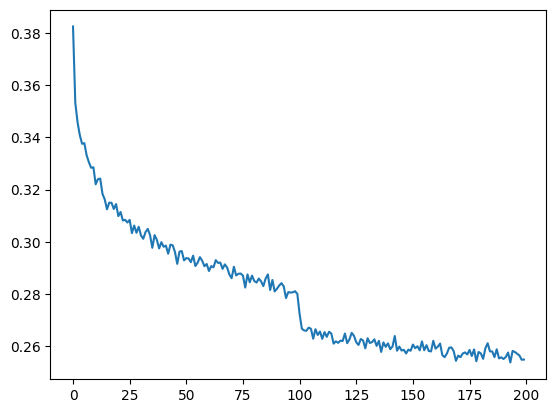

In [ ]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [ ]:
split_loss("train")
split_loss("dev")

train 1.7833975553512573
dev 1.980329990386963


# Performance Insights

for context length 3 : we got **train-error : 2.06** and **dev-error : 2.11**

for context length 8 : we got **train-error : 1.92** and **dev-error : 2.04**

flat (wavenet) : we got **train-error : 1.91** and **dev-error : 2.04**

scaling the net : we got **train-error : 1.78** and **dev-error : 1.98**

In [ ]:
# Now Convultions, a small brief.

In [ ]:
# Lets take an example
for x,y in zip(Xtr[7:15],Ytr[7:15]):
  print(''.join(itos[ix.item()]  for ix in x ), '--->', itos[y.item()])

<S><S><S><S><S><S><S><S> ---> k
<S><S><S><S><S><S><S>k ---> e
<S><S><S><S><S><S>ke ---> a
<S><S><S><S><S>kea ---> l
<S><S><S><S>keal ---> a
<S><S><S>keala ---> n
<S><S>kealan ---> i
<S>kealani ---> <E>


In [ ]:
# forward a single example :
logits = model(Xtr[[7]]) # why not Xtr[7] -> it causes error due to shapes
logits.shape

/tmp/ipython-input-3968922413.py:39: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  xvar = x.var(dim, keepdim=True) # batch variance


torch.Size([1, 28])

In [ ]:
# forwarding all of the above examples
logits = torch.zeros(8,28)
for i in range(8):
  logits[i] = model(Xtr[[7+i]])
logits.shape

/tmp/ipython-input-3968922413.py:39: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  xvar = x.var(dim, keepdim=True) # batch variance


torch.Size([8, 28])

In [ ]:
# As we can see above we are manually doing a for loop here, but in convultion layer, the for loop will be handled inside the net,
# and it is more efficient because the loop is occuring inside the net in cuda and the inputs slide through the network and if we observe the wavenet image above, it is
# basically a tree structure with left and right child and these child values will be calculated once and used multiple times
# (twice generally) unlike the above where we have to calculate them again and again.